In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))
import database as db

05:55:58 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Autosave disabled


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:8753d14632a44ff2b3a6730b9ada3457
n01:767a29863dbd47c1ba94c20e079807dd
[n0:8753d14632a44ff2b3a6730b9ada3457, n01:767a29863dbd47c1ba94c20e079807dd, n02:c2ab97f87cb14a74968ba5da81d73357, n011:224c9968b35b4dc8a5dd3607e30c61c4, n012:c85e5ef96a0e49d6a4950c6f640cecaf]


## initialize db

In [4]:
db_path = "/tmp/test_uuid.sqlite"
if os.path.exists(db_path):
    os.remove(db_path)
db.initialize(db_path)

## add nodes

In [5]:
for node in nodes:
    db.atomic(db_path, db.add_node(node.data, node.uuid))

## add edges

In [6]:
for node in nodes:
    if node.parent is not None and node.uuid is not None:
        print("{} -> {}".format(node.parent, node.uuid))
        db.atomic(db_path, db.connect_nodes(node.parent, node.uuid, {'parent': node.parent}))


8753d14632a44ff2b3a6730b9ada3457 -> 767a29863dbd47c1ba94c20e079807dd
8753d14632a44ff2b3a6730b9ada3457 -> c2ab97f87cb14a74968ba5da81d73357
767a29863dbd47c1ba94c20e079807dd -> 224c9968b35b4dc8a5dd3607e30c61c4
767a29863dbd47c1ba94c20e079807dd -> c85e5ef96a0e49d6a4950c6f640cecaf


## get node by uuid

In [7]:
rn0 = db.atomic(db_path, db.find_node(n0.uuid))
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': '8753d14632a44ff2b3a6730b9ada3457', '!parent': None, 'id': '8753d14632a44ff2b3a6730b9ada3457'}


## get all nodes

In [8]:
db.atomic(db_path, db.find_nodes({'name': ''}, db._search_like, db._search_starts_with))

[{'name': 'n0',
  'uuid': '8753d14632a44ff2b3a6730b9ada3457',
  '!parent': None,
  'id': '8753d14632a44ff2b3a6730b9ada3457'},
 {'name': 'n01',
  'uuid': '767a29863dbd47c1ba94c20e079807dd',
  '!parent': '8753d14632a44ff2b3a6730b9ada3457',
  'id': '767a29863dbd47c1ba94c20e079807dd'},
 {'name': 'n02',
  'uuid': 'c2ab97f87cb14a74968ba5da81d73357',
  '!parent': '8753d14632a44ff2b3a6730b9ada3457',
  'id': 'c2ab97f87cb14a74968ba5da81d73357'},
 {'name': 'n011',
  'uuid': '224c9968b35b4dc8a5dd3607e30c61c4',
  '!parent': '767a29863dbd47c1ba94c20e079807dd',
  'id': '224c9968b35b4dc8a5dd3607e30c61c4'},
 {'name': 'n012',
  'uuid': 'c85e5ef96a0e49d6a4950c6f640cecaf',
  '!parent': '767a29863dbd47c1ba94c20e079807dd',
  'id': 'c85e5ef96a0e49d6a4950c6f640cecaf'}]

In [9]:
rn011 = db.atomic(db_path, db.find_node(n011.uuid))
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': '224c9968b35b4dc8a5dd3607e30c61c4', '!parent': '767a29863dbd47c1ba94c20e079807dd', 'id': '224c9968b35b4dc8a5dd3607e30c61c4'}


In [10]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [11]:
ids = [n.uuid for n in nodes]
# print(ids)

dotstr = db.get_dot(db_path, path=ids)
# print("!", dotstr)

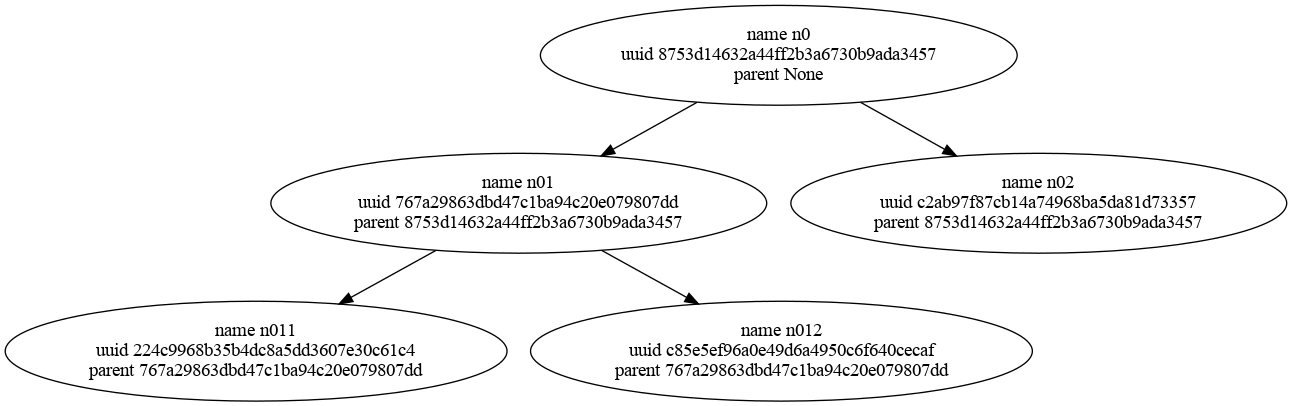

In [12]:
draw(dotstr)
